In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import concatenate, Dense, Input, Flatten
from keras.optimizers import Adam

import sys
sys.path.append('../module/')

import gym2
from rl2.agents import eventDDPGAgent
from rl2.memory import SequentialMemory

Using TensorFlow backend.


In [12]:
# GymのPendulum環境を作成
dt = 0.005
env = gym2.make("Pendulum-v1", dt)
clip = 10.
env.max_torque, max_torque = clip, clip
env.action_space.high, env.action_space.low = max_torque, -max_torque

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [13]:
def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(3, activation="tanh")(x)
    actor = Model(inputs=action_input, outputs=x)
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

In [14]:
def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = eventDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01
    )
    return agent

In [18]:
#safe learning
l = 0.5
step = 600000
episode_step = int(200 * 0.05 / dt)
time_mode = False
a = agent((3,), env.observation_space.shape)
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
#a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
a.fit(env, lam=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step, loss_graph=0, time_mode=time_mode)

Training for 600000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 41s 4ms/step - reward: -7.1718
5 episodes - episode_reward: -14343.584 [-17133.583, -5534.005] - loss: 65368.917 - mean_absolute_error: 26.196 - mean_q: -13.108

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 44s 4ms/step - reward: -7.2969
5 episodes - episode_reward: -14593.775 [-16662.026, -12403.674] - loss: 208379.031 - mean_absolute_error: 48.654 - mean_q: -29.045

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 44s 4ms/step - reward: -7.8170
5 episodes - episode_reward: -15634.056 [-16568.179, -14596.791] - loss: 175119.047 - mean_absolute_error: 43.715 - mean_q: -60.907

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 46s 5ms/step - reward: -8.5279
5 episodes - episode_reward: -17055.747 [-17529.379, -16627.874] - loss: 313589.875 - mean_absolute_error: 76.857 - mean_q: -

10000/10000 [==============================] - 47s 5ms/step - reward: -1.7128
5 episodes - episode_reward: -3425.676 [-16884.047, -53.336] - loss: 4515447.000 - mean_absolute_error: 193.963 - mean_q: -438.912

Interval 35 (340000 steps performed)
10000/10000 [==============================] - 47s 5ms/step - reward: -3.4345
5 episodes - episode_reward: -6869.029 [-15730.260, -61.702] - loss: 2273968.750 - mean_absolute_error: 137.364 - mean_q: -323.022

Interval 36 (350000 steps performed)
10000/10000 [==============================] - 48s 5ms/step - reward: -2.7871
5 episodes - episode_reward: -5574.206 [-15703.843, -66.854] - loss: 11197.864 - mean_absolute_error: 28.624 - mean_q: -284.038

Interval 37 (360000 steps performed)
10000/10000 [==============================] - 47s 5ms/step - reward: -5.3475
5 episodes - episode_reward: -10695.027 [-16575.227, -729.563] - loss: 70736.797 - mean_absolute_error: 43.615 - mean_q: -325.069

Interval 38 (370000 steps performed)
10000/10000 [===

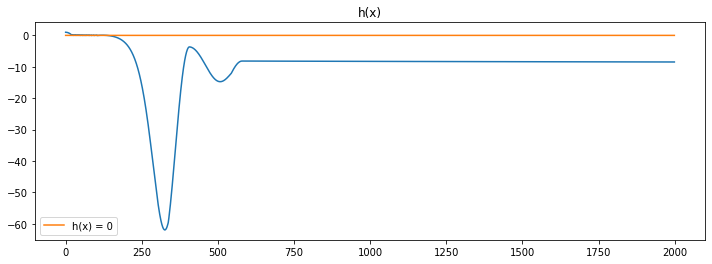

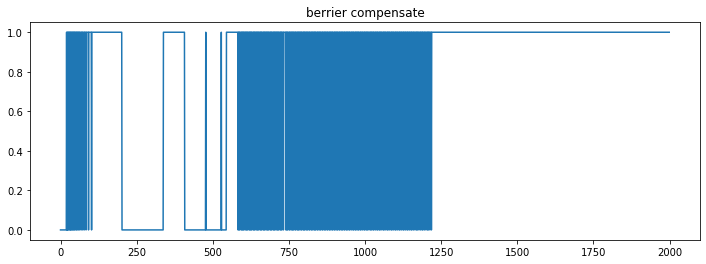

In [22]:
# first episode log
episode_step = int(200 * 0.05 / dt)
plt.figure(figsize=(12,4))
plt.title('h(x)')
plt.plot(range(episode_step), a.cbf_log[:episode_step,0])
plt.plot(range(episode_step), np.zeros(episode_step,), label='h(x) = 0')
#plt.ylim(-10,1)
plt.legend()
plt.show()
plt.figure(figsize=(12,4))
plt.title('berrier compensate')
plt.plot(range(episode_step), a.cbf_log[:episode_step,1])
plt.show()

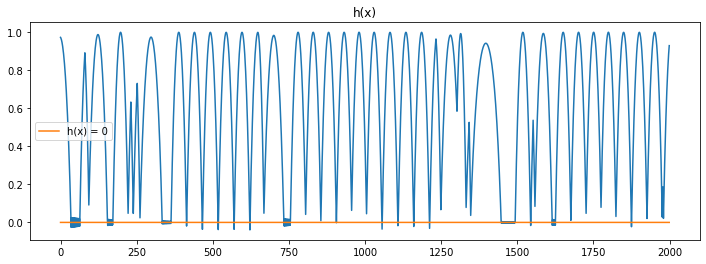

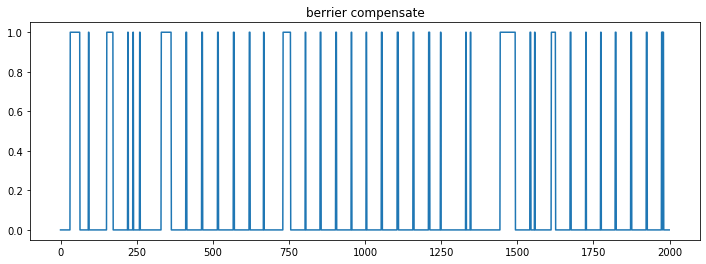

In [25]:
# log per episode
interval = 51
plt.figure(figsize=(12,4))
plt.title('h(x)')
plt.plot(range(episode_step), a.cbf_log[episode_step * interval : episode_step * (interval+1), 0])
plt.plot(range(episode_step), np.zeros(episode_step ,), label='h(x) = 0')
#plt.ylim(-10,1)
plt.legend()
plt.show()
plt.figure(figsize=(12,4))
plt.title('berrier compensate')
plt.plot(range(episode_step), a.cbf_log[episode_step * interval : episode_step * (interval+1),1])
plt.show()

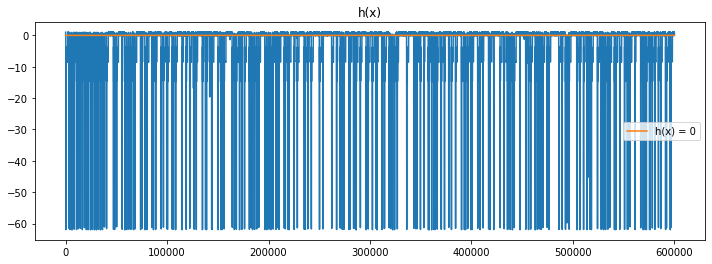

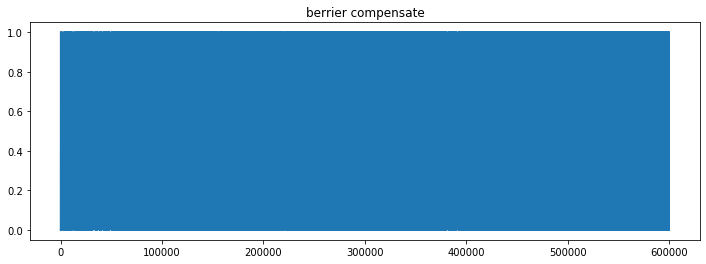

In [23]:
# log throughout learning
plt.figure(figsize=(12,4))
plt.title('h(x)')
plt.plot(range(step), a.cbf_log[:,0])
plt.plot(range(step), np.zeros(step,), label='h(x) = 0')
#plt.ylim(-10,1)
plt.legend()
plt.show()
plt.figure(figsize=(12,4))
plt.title('berrier compensate')
plt.plot(range(step), a.cbf_log[:,1])
plt.show()

In [19]:
#a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
a.test(env, lam=l, visualize=0, nb_max_episode_steps=episode_step, action_view=0, time_mode=time_mode)

Testing for 1 episodes ...
Episode 1: reward: -162553.204, steps: 20000


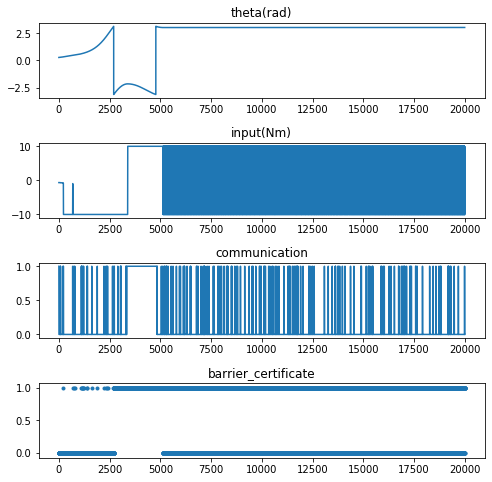

In [20]:
titles = ['theta(rad)', 'input(Nm)', 'communication', 'barrier_certificate'] 
history = a.data_log[0]
x_axis = range(episode_step)
plt.figure(figsize=(8,8))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(4):
    data = history[:,i]
    plt.subplot(4,1,i+1)
    plt.title(titles[i])
    plt.plot(x_axis, data)
plt.show()

In [20]:
a.save_weights('../learned_models_safe/600000_e2000_l05.h5')

(array([ 949.,   11.,    0.,    0.,    4.,   12.,    5.,    3.,    3.,
        1013.]),
 array([-3.14158925e+00, -2.51327466e+00, -1.88496007e+00, -1.25664549e+00,
        -6.28330898e-01, -1.63091561e-05,  6.28298279e-01,  1.25661287e+00,
         1.88492746e+00,  2.51324205e+00,  3.14155663e+00]),
 <a list of 10 Patch objects>)

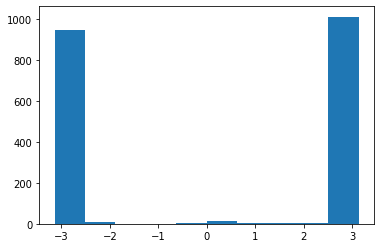

In [11]:
plt.hist(history[:,0])

In [26]:
import csv

with open("../learning_log.csv", "w") as f:
    writer = csv.writer(f)
    for row in a.cbf_log:
        writer.writerow(row)